<a href="https://colab.research.google.com/github/michellecxy015/ml-finacne/blob/main/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

feature select

✅ Top features by rolling IC:
        mean_ic
DY    0.207023
YSS   0.110658
MOV   0.072364
_TY   0.058585
M2    0.013391
UN    0.008109
_AU   0.004468
STP   0.003033
_DXY  0.001623
MG   -0.000212


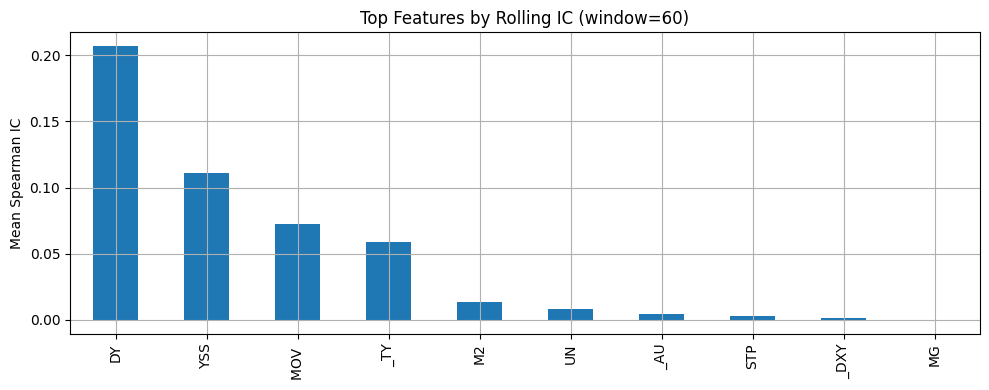

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# === Step 1: 加载数据 ===
df = pd.read_excel("market_data.xlsx", sheet_name="US").dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# === Step 2: 构造目标变量 ===
df['target'] = df['_MKT'].pct_change().shift(-1)
df = df.dropna()

# === Step 3: 修正后的滑窗 IC 函数 ===
def rolling_ic(df, feature, target='target', window=60):
    f = df[feature]
    t = df[target]
    return f.rolling(window).corr(t)

# === Step 4: 遍历特征计算平均 IC ===
feature_cols = [col for col in df.columns if col not in ['_MKT', 'target']]
ic_summary = {}

for feat in feature_cols:
    ic_series = rolling_ic(df, feat, target='target', window=60)
    ic_summary[feat] = ic_series.mean()

# === Step 5: 排序 & 输出前十名特征 ===
ic_df = pd.DataFrame.from_dict(ic_summary, orient='index', columns=["mean_ic"]).dropna()
ic_df = ic_df.sort_values(by="mean_ic", ascending=False)
top_features = ic_df.head(10)
print("✅ Top features by rolling IC:\n", top_features)

# === Step 6: 可视化 ===
plt.figure(figsize=(10, 4))
top_features['mean_ic'].plot(kind='bar')
plt.title("Top Features by Rolling IC (window=60)")
plt.ylabel("Mean Spearman IC")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Select your top features
top_features = ['DY', 'YSS', 'MOV ', '_TY', 'M2', 'UN', '_AU', 'STP', '_DXY', 'MG']
results = []

# -----------------------
# Step 2: Try all 2–4 feature combinations
# -----------------------
for k in [2, 3, 4]:
    for feature_combo in combinations(top_features, k):
        X = df[list(feature_combo)].copy()
        y = df['target'].copy()

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Time-series split (no shuffle)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

        # Build simple DNN model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])

        # Predict
        preds = model.predict(X_scaled).flatten()

        # Evaluate
        ic = spearmanr(preds, y)[0]
        excess_returns = preds * df['_MKT'].shift(-1)
        sharpe = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

        results.append({
            'features': feature_combo,
            'IC': ic,
            'Sharpe': sharpe
        })

# -----------------------
# Step 3: Show Best Results
# -----------------------
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by='IC', ascending=False).reset_index(drop=True)

print("✅ Top Combinations by Spearman IC:")
print(result_df.head(10))
result_df.to_csv("dnn_combo_results.csv", index=False)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━

evaluation


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def compute_rolling_sharpe(returns, window=12):
    rolling_mean = returns.rolling(window=window).mean()
    rolling_std = returns.rolling(window=window).std()
    return rolling_mean / rolling_std

def evaluate_strategy_with_dnn(data, signal_set, hidden_layers=[32, 16], window=12):
    df = data.dropna().copy()
    df = df[df.columns.intersection(signal_set + ('RET',))].dropna()

    X = df[list(signal_set)]
    y = df['RET']
    dates = df.index

    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分训练测试集
    X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
        X_scaled, y, dates, test_size=0.2, shuffle=False
    )

    # 构建 Keras DNN
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))  # 回归输出

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # 预测
    y_pred = model.predict(X_test).flatten()

    # 指标计算
    ic, _ = spearmanr(y_test, y_pred)
    strategy_returns = y_test * np.sign(y_pred)
    sharpe = strategy_returns.mean() / strategy_returns.std()

    # 绘图：预测 vs 真实
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, y_test, label='True Returns')
    plt.plot(date_test, y_pred, label='Predicted Signal')
    plt.title(f'Prediction vs True | {signal_set}\nIC={ic:.3f}, Sharpe={sharpe:.2f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 策略 vs 标的累计收益
    strategy_cum = strategy_returns.cumsum()
    underlying_cum = y_test.cumsum()

    plt.figure(figsize=(12, 4))
    plt.plot(date_test, strategy_cum, label='Strategy Cumulative PnL')
    plt.plot(date_test, underlying_cum, label='Underlying Cumulative Return')
    plt.title(f'Strategy Backtest | {signal_set}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Rolling Sharpe Ratio
    rolling_sharpe = compute_rolling_sharpe(strategy_returns, window=window)
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, rolling_sharpe)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Rolling Sharpe Ratio | {signal_set}')
    plt.xlabel("Time")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'ic': ic,
        'sharpe': sharpe,
        'rolling_sharpe': rolling_sharpe
    }

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


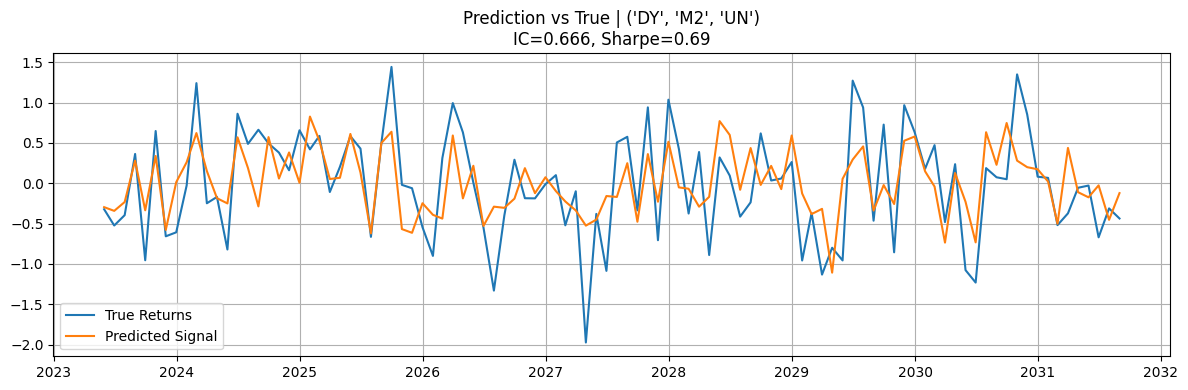

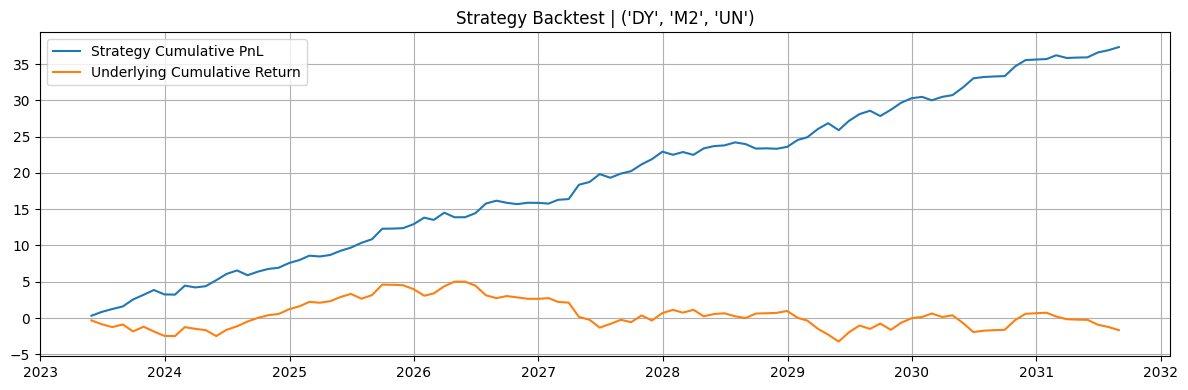

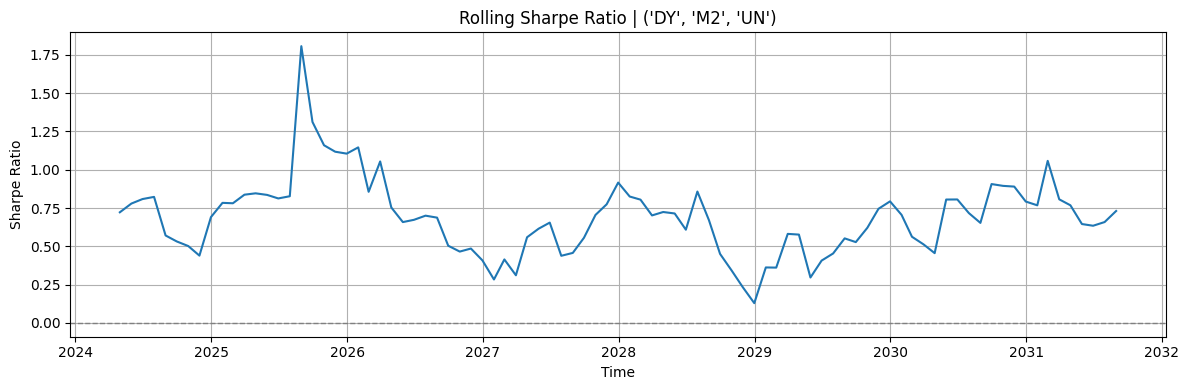

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


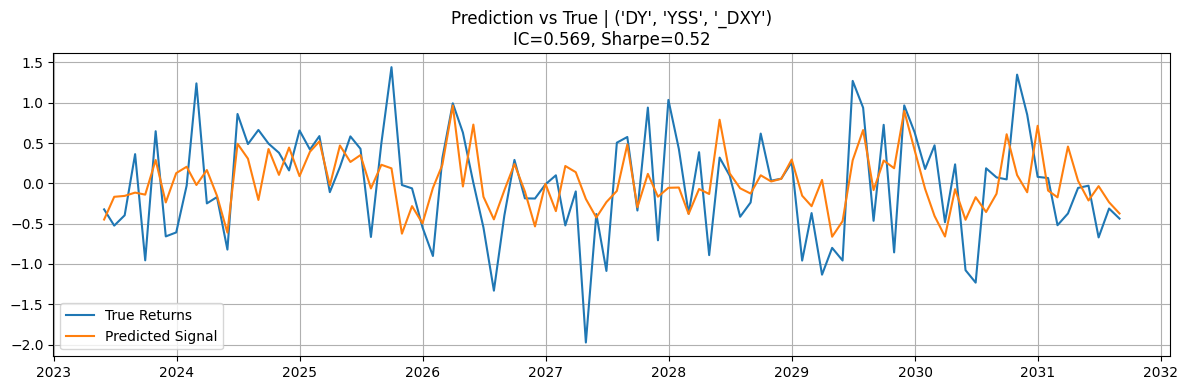

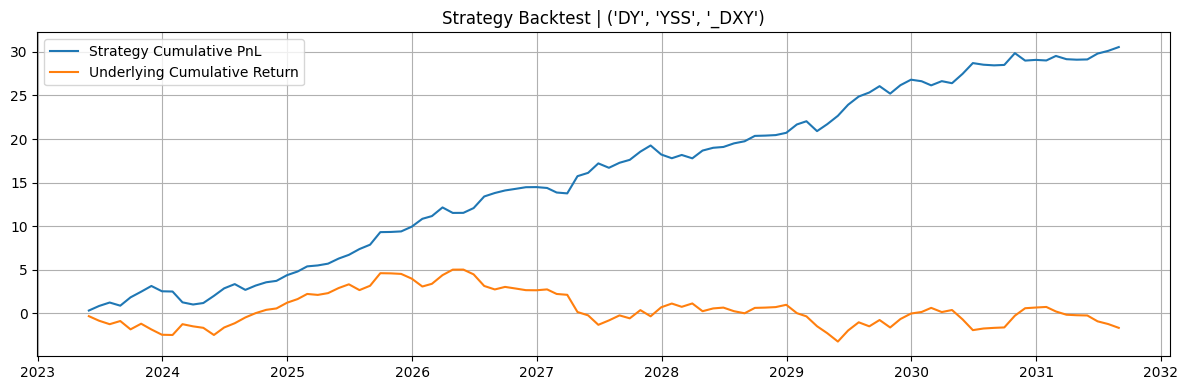

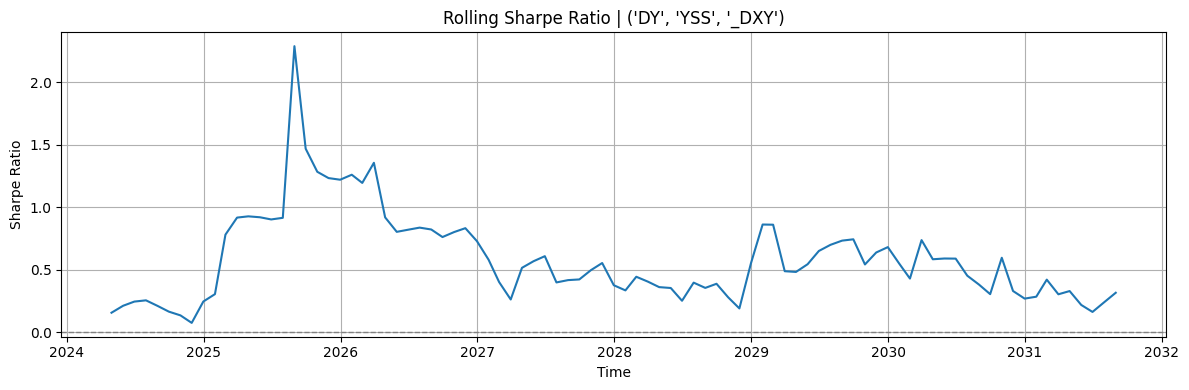

In [15]:
signal_1 = ('DY', 'M2', 'UN')
signal_2 = ('DY', 'YSS', '_DXY')

result_1 = evaluate_strategy_with_dnn(df,signal_1)
result_2 = evaluate_strategy_with_dnn(df, signal_2)